## Imports

In [1]:
from typing import Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pyro
import pyro.distributions as dist
import pyro.infer as infer
import pyro.optim as optim
import torch
import torch.nn as nn
from scipy.stats import norm
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import warnings
warnings.filterwarnings("ignore", module="torchvision.datasets")

In [2]:
from src.models import *
from src.functions import *
from src.data import *
from src.rvae import *
from src.trainer import *
from src.classifier import *
from src.steps import *
from src.similarity import *

In [3]:
%load_ext autoreload
%autoreload 3

In [4]:
mnist_trainset = datasets.MNIST('data/mnist/', train=True, download=True)
mnist_testset = datasets.MNIST('data/mnist/', train=False, download=True)

In [5]:
print(torch.cuda.is_available())
print(torch.__version__)
print(torch.cuda.device_count())

False
2.0.0+cpu
0


## Transforming Dataset 

In [8]:
train_data, train_labels, translations, angles = get_mnist_data(
    mnist_trainset, 
    [2,4,6,8], 
    translation_range=[-10, 11], 
    rotation_range=[-60, 61])

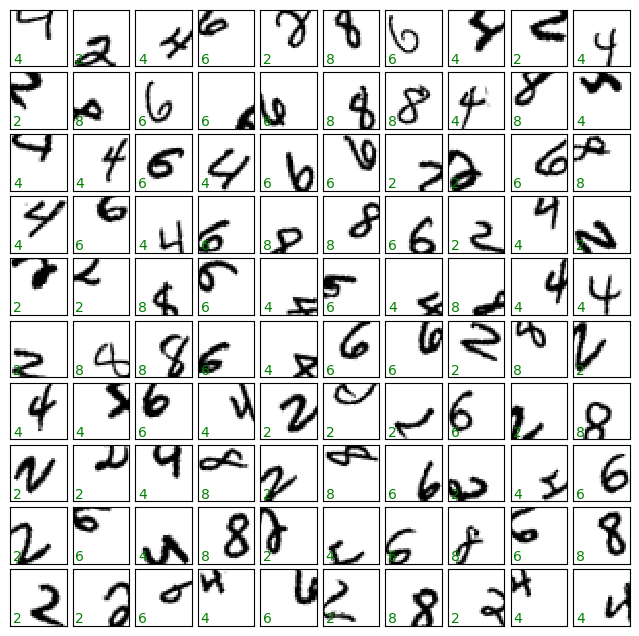

In [9]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax, im, lbl in zip(axes.flat, train_data, train_labels):
    ax.imshow(im, cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(lbl.item()),
            transform=ax.transAxes, color='green')

## ROC

In [8]:
# trainset, coord, model_coord path, labels, latent_dim, in_dim, hidden_dim_e, hidden_dim_d, batch_size, epochs
train_vae(mnist_trainset, 2, 0, 'saved_models/WWvae.pkl', [0, 1, 2, 3, 4], epochs=5, hidden_dim_e=32, hidden_dim_d=32)
train_vae(mnist_trainset, 2, 2, 'saved_models/WWtvae.pkl', [0, 1, 2, 3, 4], epochs=5, hidden_dim_e=32, hidden_dim_d=32)

 20%|████████████████▊                                                                   | 1/5 [00:03<00:15,  4.00s/it]

Epoch: 1 Training loss: 304.4270


 40%|█████████████████████████████████▌                                                  | 2/5 [00:08<00:13,  4.46s/it]

Epoch: 2 Training loss: 264.5818


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:13<00:09,  4.76s/it]

Epoch: 3 Training loss: 262.3272


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:18<00:04,  4.74s/it]

Epoch: 4 Training loss: 261.8587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:24<00:00,  4.95s/it]

Epoch: 5 Training loss: 242.4755



 20%|████████████████▊                                                                   | 1/5 [00:28<01:55, 28.96s/it]

Epoch: 1 Training loss: 289.3689


 40%|█████████████████████████████████▌                                                  | 2/5 [00:58<01:27, 29.01s/it]

Epoch: 2 Training loss: 269.4305


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:02<01:30, 45.25s/it]

Epoch: 3 Training loss: 227.5290


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:30<00:38, 38.52s/it]

Epoch: 4 Training loss: 199.5062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:07<00:00, 37.48s/it]

Epoch: 5 Training loss: 194.9652


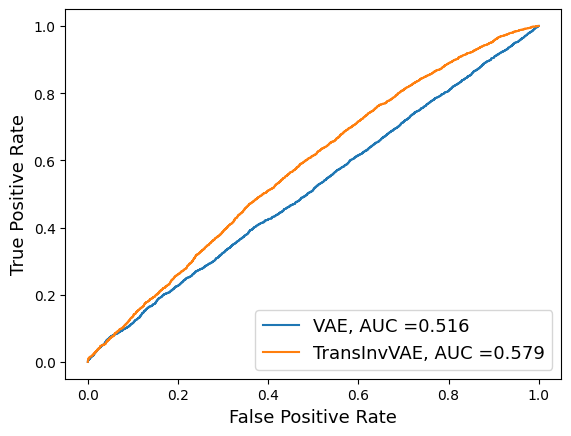

In [7]:
vae = rVAE((28, 28), coord=0, hidden_dim_e=32, hidden_dim_d=32)
trainer = SVItrainer(vae)
trainer.load_model(vae, 'saved_models/WWvae.pkl')
auc, fpr, tpr, thresholds = pair_matching(mnist_testset, [5,6,7,8,9], vae, 2, 0)
plt.plot(fpr,tpr,label="VAE, AUC ="+"%.3f" % auc)

tvae = rVAE((28, 28), coord=2, hidden_dim_e=32, hidden_dim_d=32)
trainer = SVItrainer(tvae)
trainer.load_model(tvae, 'saved_models/WWtvae.pkl')
auc, fpr, tpr, thresholds = pair_matching(mnist_testset, [5,6,7,8,9], tvae, 2, 2)
plt.plot(fpr,tpr,label="TransInvVAE, AUC ="+"%.3f" % auc)


plt.legend(loc='lower right', fontsize=13)
plt.xlabel('False Positive Rate', fontsize = 13)
plt.ylabel('True Positive Rate', fontsize = 13)
# plt.savefig("plots/xxx", bbox_inches='tight')
plt.show()